# Test my idea of train 2 pairs of Gans at the same time

In [12]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [13]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [14]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [15]:
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('generator', reuse=reuse): # finish this
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(z, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

In [16]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('discriminator', reuse=reuse): # finish this
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1 * alpha, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

## Hyperparameter

In [17]:
# Size of input image to discriminator
input_size = 784 # 28x28 MNIST images flattened
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
smooth = 0.1

## Build Networks

In [18]:
tf.reset_default_graph()

input_real, input_z = model_inputs(input_size, z_size)

# Generative network 1
with tf.variable_scope('1'):
    g_model_1 = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)
    
# Generative network 2
with tf.variable_scope('2'):
    g_model_2 = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)
    
# An empty network for buffer parameter, called generative network 3
with tf.variable_scope('3'):
    g_model_3 = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)
    
# Discriminator network 1
with tf.variable_scope('1'):
    d_model_real_1, d_logits_real_1 = discriminator(input_real, d_hidden_size, reuse=False, alpha=alpha)
    d_model_fake_1, d_logits_fake_1 = discriminator(g_model_1, d_hidden_size, reuse=True, alpha=alpha)
    
# Discriminator network 2
with tf.variable_scope('2'):
    d_model_real_2, d_logits_real_2 = discriminator(input_real, d_hidden_size, reuse=False, alpha=alpha)
    d_model_fake_2, d_logits_fake_2 = discriminator(g_model_2, d_hidden_size, reuse=True, alpha=alpha)

In [19]:
# Calculate losses 1
d_loss_real_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_real_1, labels=tf.ones_like(d_logits_real_1) * (1 - smooth)))

d_loss_fake_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_fake_1, labels=tf.zeros_like(d_logits_fake_1)))

d_loss_1 = d_loss_real_1 + d_loss_fake_1

g_loss_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_fake_1, labels=tf.ones_like(d_logits_fake_1)))

# Calculate losses 2
d_loss_real_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_real_2, labels=tf.ones_like(d_logits_real_2) * (1 - smooth)))

d_loss_fake_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_fake_2, labels=tf.zeros_like(d_logits_fake_2)))

d_loss_2 = d_loss_real_2 + d_loss_fake_2

g_loss_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_fake_2, labels=tf.ones_like(d_logits_fake_2)))

In [20]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars_1 = [var for var in t_vars if var.name.startswith('1/generator')]
d_vars_1 = [var for var in t_vars if var.name.startswith('1/discriminator')]

g_vars_2 = [var for var in t_vars if var.name.startswith('2/generator')]
d_vars_2 = [var for var in t_vars if var.name.startswith('2/discriminator')]

# Get the variable of the buffering network
g_vars_3 = [var for var in t_vars if var.name.startswith('3/generator')]

d_train_opt_1 = tf.train.AdamOptimizer(learning_rate).minimize(d_loss_1, var_list=d_vars_1)
g_train_opt_1 = tf.train.AdamOptimizer(learning_rate).minimize(g_loss_1, var_list=g_vars_1)

d_train_opt_2 = tf.train.AdamOptimizer(learning_rate).minimize(d_loss_2, var_list=d_vars_2)
g_train_opt_2 = tf.train.AdamOptimizer(learning_rate).minimize(d_loss_2, var_list=g_vars_2)

In [21]:
# Swap operation
swap_ops = []
# First, assign the values of weight of generator 1 to 3
for g_var_1, g_var_3 in zip(sorted(g_vars_1, key=lambda v: v.name),
                            sorted(g_vars_3, key=lambda v: v.name)):
    swap_ops.append(g_var_3.assign(g_var_1))
    
# Then assign the values of weight of generator 2 to 1
for g_var_2, g_var_1 in zip(sorted(g_vars_2, key=lambda v: v.name),
                            sorted(g_vars_1, key=lambda v: v.name)):
    swap_ops.append(g_var_1.assign(g_var_2))
    
# Last, assign the values of weight of generator 3 to 2
for g_var_3, g_var_2 in zip(sorted(g_vars_3, key=lambda v: v.name),
                            sorted(g_vars_2, key=lambda v: v.name)):
    swap_ops.append(g_var_2.assign(g_var_3))

## Training

In [23]:
batch_size = 100
epochs = 100
swap_every = 5
samples = []
losses_1 = []
saver = tf.train.Saver(var_list = g_vars_1)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        
        #swap the weights
        if e != 0 and e % swap_every == 0:
            sess.run(swap_ops)
        
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run([d_train_opt_1, d_train_opt_2], feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run([g_train_opt_1, g_train_opt_2], feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d_1 = sess.run(d_loss_1, {input_z: batch_z, input_real: batch_images})
        train_loss_g_1 = g_loss_1.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d_1),
              "Generator Loss: {:.4f}".format(train_loss_g_1))    
        # Save losses to view after training
        losses_1.append((train_loss_d_1, train_loss_g_1))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        with tf.variable_scope('1'):
            gen_samples_1 = sess.run(
                           generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                           feed_dict={input_z: sample_z})
            samples.append(gen_samples_1)
            saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.4592... Generator Loss: 3.3171
Epoch 2/100... Discriminator Loss: 0.3749... Generator Loss: 4.1447
Epoch 3/100... Discriminator Loss: 0.4767... Generator Loss: 4.2708
Epoch 4/100... Discriminator Loss: 0.7165... Generator Loss: 2.1303
Epoch 5/100... Discriminator Loss: 0.9247... Generator Loss: 1.5397
Epoch 6/100... Discriminator Loss: 0.3620... Generator Loss: 4.3996
Epoch 7/100... Discriminator Loss: 0.4731... Generator Loss: 2.8037
Epoch 8/100... Discriminator Loss: 0.7066... Generator Loss: 3.8125
Epoch 9/100... Discriminator Loss: 1.0530... Generator Loss: 1.4612
Epoch 10/100... Discriminator Loss: 1.1485... Generator Loss: 1.3559
Epoch 11/100... Discriminator Loss: 1.0702... Generator Loss: 1.0921
Epoch 12/100... Discriminator Loss: 0.8166... Generator Loss: 2.1243
Epoch 13/100... Discriminator Loss: 0.8829... Generator Loss: 2.6060
Epoch 14/100... Discriminator Loss: 0.7001... Generator Loss: 3.3182
Epoch 15/100... Discriminator Loss: 1.0525.

## Training Loss

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt

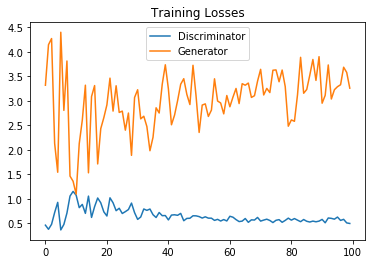

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses_1)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generate sample from training

In [26]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [27]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

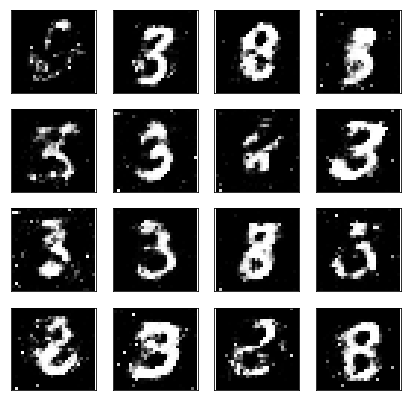

In [28]:
_ = view_samples(-1, samples)

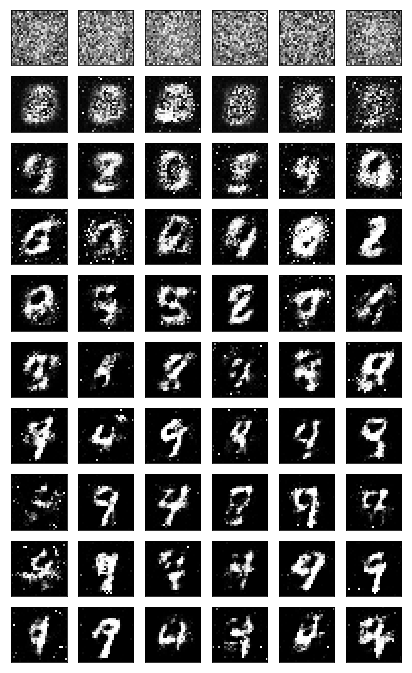

In [29]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Sampling from generator

(<matplotlib.figure.Figure at 0x7f68fcd31dd8>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68f478f390>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f68f97a60b8>]], dtype=object))

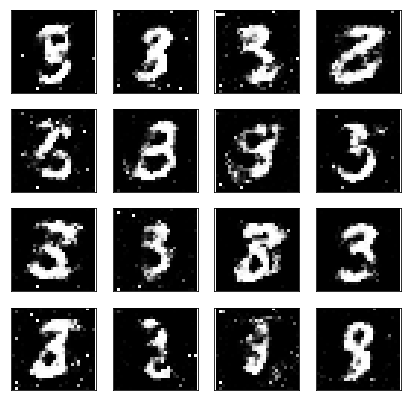

In [31]:
saver = tf.train.Saver(var_list=g_vars_1)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    with tf.variable_scope('1'):
        gen_samples = sess.run(
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
view_samples(0, [gen_samples])